In [153]:
import ee
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [22]:
ee.Initialize()


In [139]:
'''###########################################/
   This script was created by SkyTruth to identify possible active mountaintop removal 
   and other surface coal mining.
   
   Playground code: https:#code.earthengine.google.com/02cbf97172a6dd9d1062ca0c6c122137
###########################################'''

'''------------------------------------ IMPORT STUDY AREA ----------------------------'''
campagna_study_area = ee.FeatureCollection('ft:1Qo6AmhdEN44vPUpyGtzPtQUUO4rygWv4MljZ-MiE');
# Get the link here: https:#www.google.com/fusiontables/DataSource?docid=1Qo6AmhdEN44vPUpyGtzPtQUUO4rygWv4MljZ-MiE

'''------------------------------------ SET NDVI THRESHOLD ---------------------------'''
NDVI_Threshold = 0.51;

'''------------------------------------- IMPORT MASK ---------------------------------'''
mask_input_60m_2015 = ee.Image('users/jerrilyn/2015mask-PM-fullstudy-area');
# Get the link here: https:#drive.google.com/file/d/0B_MArPTqurHudFp6STU4ZzJHRmc/view

''' ----------------------------------- VISUALIZATION / SETUP ------------------------------
Adds Campagna study area; various areas of interest  '''

# Map.addLayer(campagna_study_area, {}, "Study area");

# Choose your favorite area of interest! Comment out all but one:
#Map.centerObject(campagna_study_area);        # Full study extent
#Map.setCenter(-81.971744, 38.094253, 12);     # Near Spurlockville, WV
# Map.setCenter(-82.705444, 37.020257, 12);     # Near Addington, VA
#Map.setCenter(-83.224567, 37.355144, 11);     # Near Dice, KY
#Map.setCenter(-83.931184, 36.533646, 12);     # Near Log Mountain, TN

# This list will contain all output images, so as to build an ImageCollection later for video export
allMTR_list = [];

# This empty 2D array will be used for area calculation later (if performed)
MTR_area = [[],[]];

# Subregions for exporting images/videos
# geometryI   = ee.Geometry.Rectangle([-79.612, 37.3525, -82.421, 39.037])#.toGeoJSON();
# geometryII  = ee.Geometry.Rectangle([-82.421, 37.3525, -84.993, 38.942]).toGeoJSON();
# geometryIII = ee.Geometry.Rectangle([-82.421, 35.367,  -85.811, 37.3525]).toGeoJSON();
# geometryIV  = ee.Geometry.Rectangle([-79.849, 35.763,  -82.421, 37.3525]).toGeoJSON();
# exportbounds = campagna_study_area.geometry().bounds().getInfo();

counties = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM');
boon = counties.filterMetadata('FIPS', 'equals', 54005);

'''--------------------------------- IMAGE PROCESSING ---------------------------------'''
for year in range(1984,2016): # Years of interest for the study
  

    # Determine what imagery dataset to use, based off year loop; and what threshold to use
    if year <= 2011:
        imagery = ee.ImageCollection("LANDSAT/LT5_L1T_ANNUAL_GREENEST_TOA");
        NDVIbands = 43;
    
    elif year == 2012:
        imagery = ee.ImageCollection("LANDSAT/LE7_L1T_ANNUAL_GREENEST_TOA");
        NDVIbands = 43;
    
    elif year >= 2013:
        imagery = ee.ImageCollection("LANDSAT/LC8_L1T_ANNUAL_GREENEST_TOA");
        NDVIbands = 54; # Because different bands are needed for LS8

    # Select specific year for analysis
    yearImg = ee.Image(imagery.filterDate(str(year)+"-01-01", str(year)+"-12-31").first()).clip(campagna_study_area);

    # Calculate NDVI (using normalizedDifference function; select correct bands per sensor)
    if NDVIbands == 54:
        NDVI = yearImg.normalizedDifference(["B5","B4"]).clip(campagna_study_area);
    else:
        NDVI = yearImg.normalizedDifference(["B4","B3"]).clip(campagna_study_area);
    

    # Create a mask of areas that ARE NOT mines (value of 1 to locations where NDVI is <= threshold)
    lowNDVI = NDVI.where(NDVI.lte(NDVI_Threshold),1).where(NDVI.gt(NDVI_Threshold),0);

    # Create binary image containing the intersection between the LowNDVI and anywhere the inverted mask is 1
    MTR = lowNDVI.And(mask_input_60m_2015.eq(0));

    # Erode/dilate MTR sites to remove outliers (pixel clean-up)
    MTR_eroded_dialated_dialated_eroded = MTR.reduceNeighborhood(ee.Reducer.max(), ee.Kernel.euclidean(30, 'meters'))\
    .reduceNeighborhood(ee.Reducer.min(), ee.Kernel.euclidean(30, 'meters'))\
    .reduceNeighborhood(ee.Reducer.min(), ee.Kernel.euclidean(30, 'meters'))\
    .reduceNeighborhood(ee.Reducer.max(), ee.Kernel.euclidean(30, 'meters'));

    MTR_masked = MTR_eroded_dialated_dialated_eroded.updateMask(MTR_eroded_dialated_dialated_eroded);


#     Get a pixel area image, which will apply to any scale you provide
    Area = ee.Image.pixelArea();

    # The area calculation, which currently burns out the server
    areaAll = MTR_masked.multiply(Area).reduceRegion(reducer=ee.Reducer.sum(),geometry=boon, 
                                                      scale= 30,crs= 'EPSG:3857',maxPixels= 1e9)
    areaKmSq = ee.Number(areaAll.get(MTR_masked.bandNames().getInfo()[0])).divide(1000*1000);
    

    # Add these areas and their corresponding year to 2D array
    MTR_area[0].append(year);
    MTR_area[1].append(areaKmSq);
    

    start_time = datetime.date(
        year=year,
        month=1,
        day=1)
    
    end_time = start_time + datetime.timedelta(days=364)

    
    MTR_masked = MTR_masked.set('system:time_start',1000*time.mktime(start_time.timetuple()))
    MTR_masked = MTR_masked.set('system:time_end',1000*time.mktime(end_time.timetuple()))
    allMTR_list.append(MTR_masked);


In [147]:
county = []

In [148]:
for i in range(len(MTR_area[1])):
    try:
        county.append(MTR_area[1][i].getInfo())
    except:
        time.sleep(20)
        county.append(MTR_area[1][i].getInfo())
    time.sleep(15)

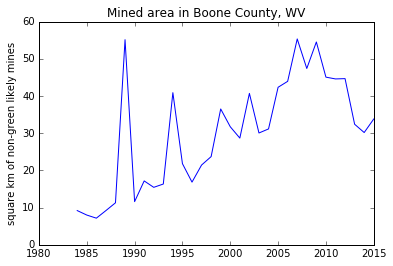

In [156]:
plt.plot(MTR_area[0],county)
plt.ylabel("square km of non-green likely mines")
plt.title("Mined area in Boone County, WV")
plt.show()

# The stuff below here doesn't work

In [26]:
allMTR = ee.ImageCollection(allMTR_list)

In [101]:
def getMean(img):
    return img.reduceRegions(boon, ee.Reducer.mean(),100)
# ans = ee.FeatureCollection(landsat8Toa.map(getMean)).flatten().aggregate_array('.all').getInfo()
ans = ee.FeatureCollection(allMTR.map(getMean)).flatten().aggregate_array('.all').getInfo()

# data = [x['properties']['values'] for x in ans]
# x_ = range(0,7)
# labels = ['B{0}'.format(x) for x in range(1,8)]

# plt.plot(data)
# plt.xticks(range(len(plt.xticks()[0])),[datetime.datetime.strptime(x['id'][:-2], "%Y%m%d").strftime('%b %Y') for x in ans])
# plt.legend(plt.plot(data),['B{0}'.format(x) for x in range(1,8)])
# plt.show()


In [116]:
for a in ans[0]:
    print a, ans[0][a]

geometry {u'type': u'Polygon', u'geodesic': True, u'coordinates': [[[-81.97856890000001, 37.996849], [-81.972855, 37.979816], [-81.959503, 37.971684], [-81.9244, 37.971142], [-81.91407, 37.954727000000005], [-81.820595, 37.94490799999999], [-81.784088, 37.929859], [-81.759315, 37.895336], [-81.77825900000002, 37.86971700000001], [-81.743202, 37.82829300000001], [-81.7172159, 37.812405], [-81.6829829, 37.825832], [-81.678818, 37.834599000000004], [-81.65244300000002, 37.832321], [-81.615089, 37.790031], [-81.580795, 37.781204], [-81.574615, 37.764168], [-81.516403, 37.797401000000015], [-81.526344, 37.830193], [-81.558975, 37.829563], [-81.565201, 37.8579409], [-81.556679, 37.894062], [-81.5655139, 37.937778], [-81.516647, 37.984303], [-81.496758, 37.97316], [-81.480209, 37.980503], [-81.454811, 37.97543], [-81.45145400000001, 38.01092100000001], [-81.481865, 38.065281000000006], [-81.495979, 38.06663500000001], [-81.510719, 38.057991], [-81.533371, 38.076297999999994], [-81.538589, 38.

In [131]:
def getArea(img):
    Area = ee.Image.pixelArea()
    # The area calculation, which currently burns out the server
#     areaAll = MTR_masked.multiply(Area).reduceRegion(reducer=ee.Reducer.sum(),geometry=boon, 
#                                                       scale= 30,crs= 'EPSG:3857',maxPixels= 1e9)

    areaAll = img.multiply(Area).reduceRegions(boon, ee.Reducer.sum(), 100,'EPSG:3857')
    
    
    areaKmSq = ee.Number(areaAll.get('nd_max_min_max')).divide(1000*1000)
    return areaKmSq
#     return areaAll

In [132]:
ans = ee.FeatureCollection(allMTR.map(getArea)).flatten().aggregate_array('.all').getInfo()

EEException: Collection.map: A mapped algorithm must return a Feature or Image.

In [98]:
print [a['properties']['sum'] for a in ans]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
